# Supervised preprocessing and visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [2]:
# Load dataset
diabetes = pd.read_csv("diabetes.csv")

In [3]:
# Get an overview of the dataset
print("Dataset dimensions: ", diabetes.shape)
print ("\nInfo datatypes:", diabetes.info())
print("\nMissing values per feature:\n", diabetes.isnull().sum())
diabetes.head()

Dataset dimensions:  (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insu    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB

Info datatypes: None

Missing values per feature:
 preg     0
plas     0
pres     0
skin     0
insu     0
mass     0
pedi     0
age      0
class    0
dtype: int64


,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


In [4]:
# Function to detect and replace outliers using IQR
# [Note AI: I had help from ChatGPT to get this section right.]
def replace_outliers_with_na(data):
   Q1 = data.quantile(0.25)
   Q3 = data.quantile(0.75)
   IQR = Q3 - Q1
   lower_bound = Q1 - 1.5 * IQR
   upper_bound = Q3 + 1.5 * IQR
   return data.apply(lambda x: np.where((x < lower_bound) | (x > upper_bound), np.nan, x))

In [5]:
# Function to detect and replace outliers using IQR (only numeric columns)
# [Note AI: ChatGPT helpd to replace the outliners correctly]
def replace_outliers_with_na(data):
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    Q1 = data[numeric_cols].quantile(0.25)
    Q3 = data[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    for col in numeric_cols:
        data[col] = np.where((data[col] < lower_bound[col]) | (data[col] > upper_bound[col]), np.nan, data[col])
    
    return data

In [6]:
# Apply outlier detection
diabetes_cleaned = replace_outliers_with_na(diabetes.copy())
diabetes_cleaned

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,tested_positive
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,tested_negative
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,tested_positive
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,tested_negative
4,0.0,137.0,40.0,35.0,168.0,43.1,NaN,33.0,tested_positive
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,tested_negative
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0,tested_negative
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,tested_negative
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0,tested_positive


In [7]:
# Handle zeros where necessary (e.g., blood pressure cannot be zero)
for col in ['plas', 'pres', 'skin', 'insu', 'mass']:
    diabetes_cleaned[col] = diabetes_cleaned[col].replace(0, np.nan)

diabetes_cleaned

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50.0,tested_positive
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31.0,tested_negative
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32.0,tested_positive
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,tested_negative
4,0.0,137.0,40.0,35.0,168.0,43.1,NaN,33.0,tested_positive
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,tested_negative
764,2.0,122.0,70.0,27.0,NaN,36.8,0.340,27.0,tested_negative
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,tested_negative
766,1.0,126.0,60.0,NaN,NaN,30.1,0.349,47.0,tested_positive


In [8]:
# Drop rows with NaN values after zero replacement
diabetes_cleaned.dropna(inplace=True)

In [9]:
# Encode categorical target variable if needed
if diabetes_cleaned['class'].dtype == 'object':
    le = LabelEncoder() # [Note AI: I got this idea from ChatGPT to encode categorial target 0 = negative, 1 = positive]
    diabetes_cleaned['class'] = le.fit_transform(diabetes_cleaned['class'])

In [10]:
# Normalize feature values for chi-squared test
scaler = MinMaxScaler()
diabetes_scaled = pd.DataFrame(scaler.fit_transform(diabetes_cleaned.iloc[:, :-1]), columns=diabetes_cleaned.columns[:-1])

In [11]:
# Compute chi2 scores
# [Note AI: Since i have little experience using this function in python, ChatGPT helped to use it correctly]
chi_scores, _ = chi2(diabetes_scaled, diabetes_cleaned['class'])
chi2_scores_diabetes = pd.DataFrame({'Feature': diabetes_cleaned.columns[:-1], 'Chi2 Score': chi_scores})
chi2_scores_diabetes.sort_values(by='Chi2 Score', ascending=False, inplace=True)

In [12]:
# Select highest and lowest ranked features
# [Note AI: Since i have little experience using this function in python, ChatGPT helped to use it correctly]
top_feature = chi2_scores_diabetes.iloc[0]['Feature']
bottom_feature = chi2_scores_diabetes.iloc[-1]['Feature']

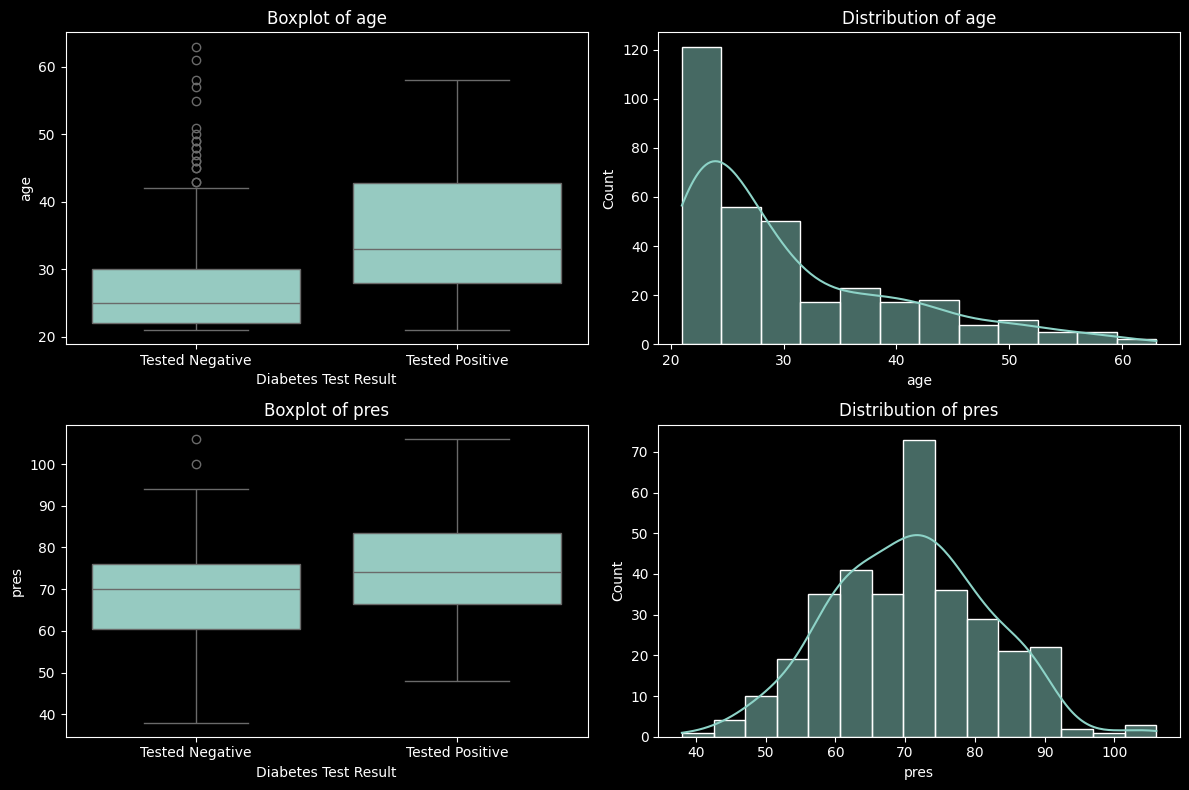

In [13]:
# Create a new column with readable class labels
# [Note AI: i asked ChatGPT how to add categorial target into the plot]
diabetes_cleaned['class_label'] = diabetes_cleaned['class'].map({0: 'Tested Negative', 1: 'Tested Positive'})

# Plot boxplots and distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.boxplot(x=diabetes_cleaned['class_label'], y=diabetes_cleaned[top_feature], ax=axes[0, 0])
axes[0, 0].set_title(f'Boxplot of {top_feature}')
axes[0, 0].set_xlabel('Diabetes Test Result')

sns.histplot(diabetes_cleaned[top_feature], kde=True, ax=axes[0, 1])
axes[0, 1].set_title(f'Distribution of {top_feature}')

sns.boxplot(x=diabetes_cleaned['class_label'], y=diabetes_cleaned[bottom_feature], ax=axes[1, 0])
axes[1, 0].set_title(f'Boxplot of {bottom_feature}')
axes[1, 0].set_xlabel('Diabetes Test Result')

sns.histplot(diabetes_cleaned[bottom_feature], kde=True, ax=axes[1, 1])
axes[1, 1].set_title(f'Distribution of {bottom_feature}')

plt.tight_layout()
plt.show()

###  Boxplots of All Features

I was curious to see how each feature differed between tested positive and tested negative individuals. To explore this, I created boxplots for every numeric column, grouped by outcome. This helps to spot patterns, outliers, and potential predictive features.


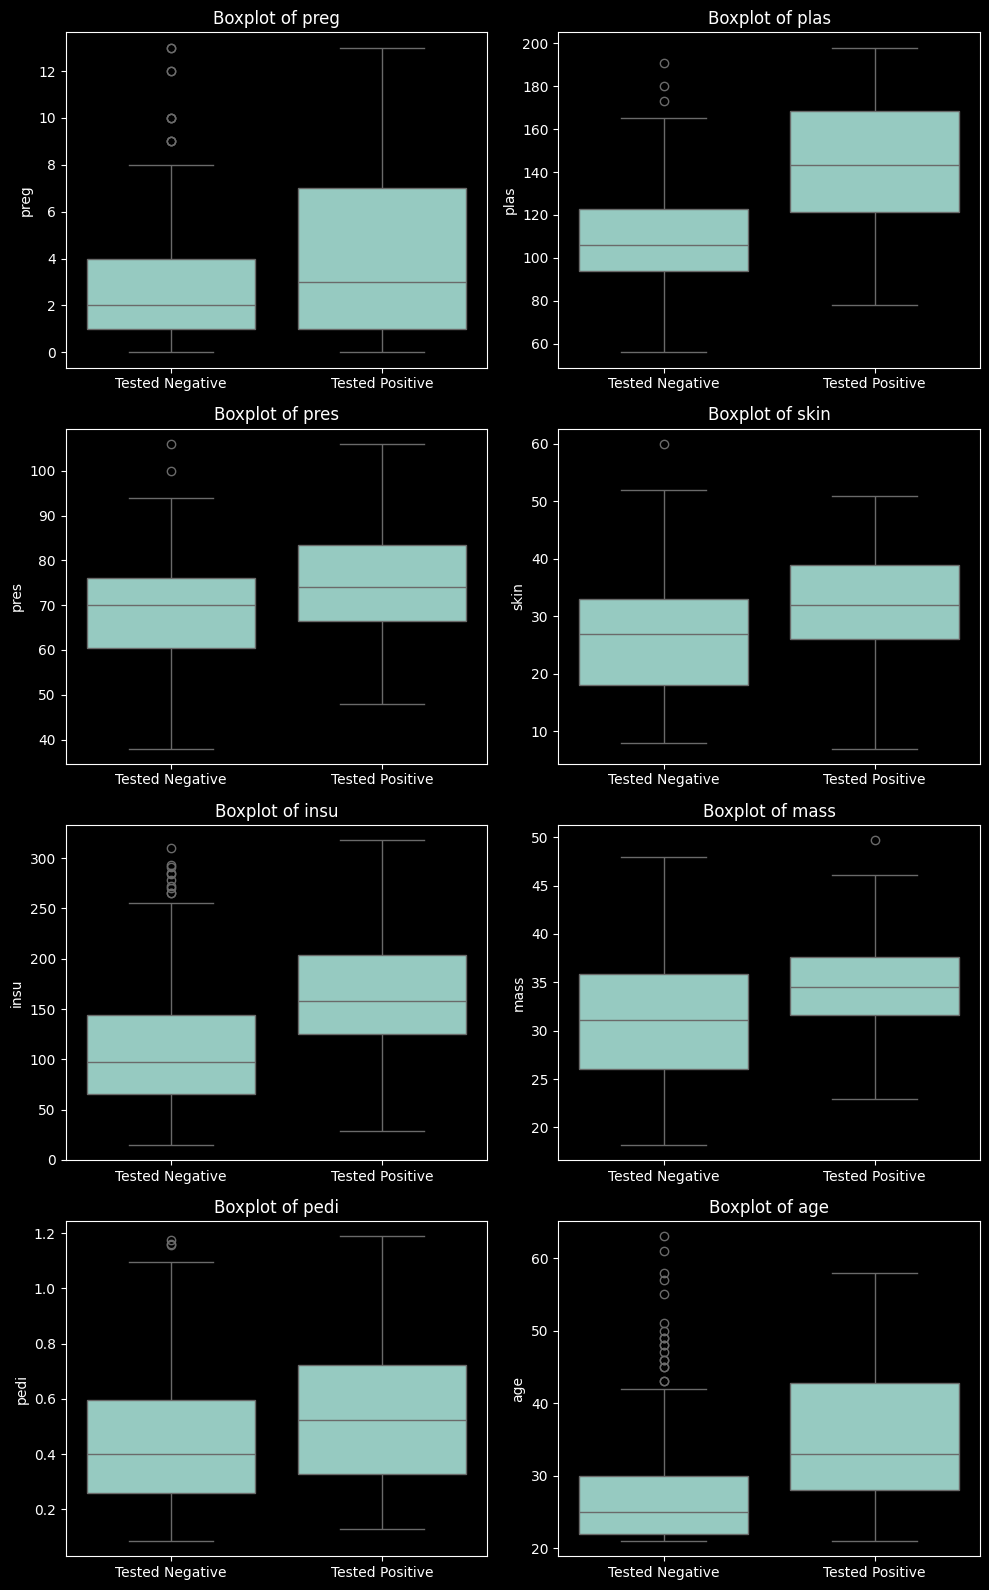

In [15]:
# [Note AI: i asked ChatGPT to create boxplots for each feature differed between tested positive and tested negative]
import math

# List of numeric features (excluding the target/class columns)
feature_cols = [col for col in diabetes_cleaned.columns if col not in ['class', 'class_label']]

# Determine layout for subplots
n_cols = 2
n_rows = math.ceil(len(feature_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Plot one boxplot per feature
for i, col in enumerate(feature_cols):
    sns.boxplot(x='class_label', y=col, data=diabetes_cleaned, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Klassifikation mit logistischer Regression

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [52]:
# Sicherstellen, dass Zielvariable numerisch ist (mit robustem Mapping)
if diabetes['class'].dtype == 'object':
    print("Warnung: class-Spalte enthält Strings – Mapping wird durchgeführt.")
    diabetes['class'] = diabetes['class'].str.strip().str.lower()
    diabetes['class'] = diabetes['class'].map({'tested_negative': 0, 'tested_positive': 1})
diabetes.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1.0
1,1,85,66,29,0,26.6,0.351,31,0.0
2,8,183,64,0,0,23.3,0.672,32,1.0
3,1,89,66,23,94,28.1,0.167,21,0.0
4,0,137,40,35,168,43.1,2.288,33,1.0


In [ ]:
# 2. Zielvariable (y) und Prädiktoren (X) festlegen
X = diabetes.drop('class', axis=1) 
y = diabetes['class']               

# 3. Modell initialisieren und trainieren
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

LogisticRegression(max_iter=1000)

### Modell auswerten

In [54]:
# 4. Modell auswerten
print("\nKoeffizienten:")
print(model.coef_)
print("Intercept:")
print(model.intercept_)


Koeffizienten:
[[ 1.22505160e-01  3.51099563e-02 -1.32987359e-02  7.78690277e-04
  -1.17362787e-03  8.96527929e-02  8.67790286e-01  1.49830228e-02]]
Intercept:
[-8.36507758]


In [55]:
# Vorhersagen erstellen
y_pred = model.predict(X)

In [56]:
# Genauigkeit ausgeben
accuracy = accuracy_score(y, y_pred)
print(f"\nGenauigkeit auf Gesamtdaten: {accuracy:.2f}")


Genauigkeit auf Gesamtdaten: 0.78


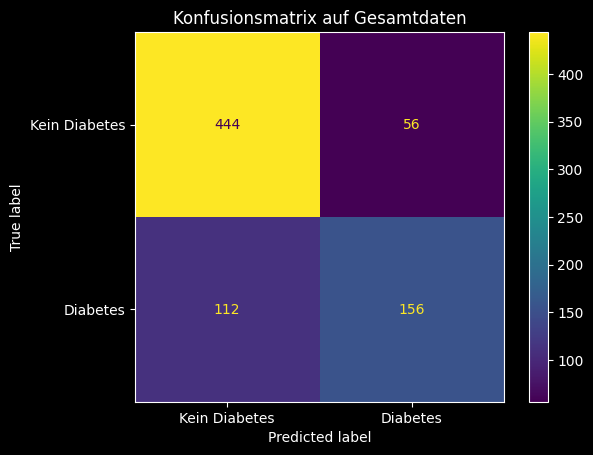

In [57]:
# Konfusionsmatrix anzeigen
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Kein Diabetes', 'Diabetes']).plot()
plt.title('Konfusionsmatrix auf Gesamtdaten')
plt.show()

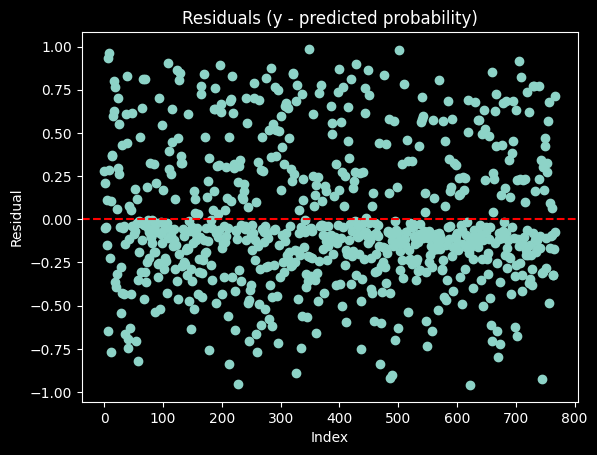

In [58]:
# Residuen visualisieren (als Differenz in Vorhersagewahrscheinlichkeiten)
y_prob = model.predict_proba(X)[:, 1]  # Wahrscheinlichkeit für Klasse 1 (Diabetes)
residuals = y.to_numpy().astype(float) - y_prob   # Differenz zwischen Wahrheit (0 oder 1) und Wahrscheinlichkeit
plt.plot(residuals, marker='o', linestyle='')
plt.title('Residuals (y - predicted probability)')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [59]:
# 5. Train-Test-Split und Modellvalidierung
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Modell trainieren
model_cv = LogisticRegression(max_iter=1000)
model_cv.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [61]:
# Testdaten vorhersagen
y_test_pred = model_cv.predict(X_test)
# Genauigkeit auf Testdaten ausgeben
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nGenauigkeit auf Testdaten: {test_accuracy:.2f}")


Genauigkeit auf Testdaten: 0.75


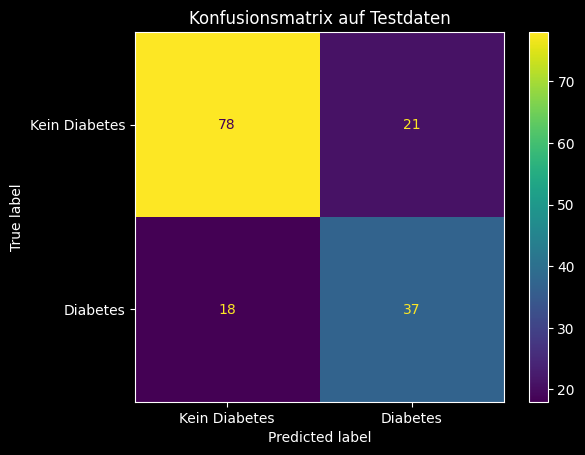

In [62]:
# Konfusionsmatrix für Testdaten anzeigen
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=['Kein Diabetes', 'Diabetes']).plot()
plt.title('Konfusionsmatrix auf Testdaten')
plt.show()